In [1]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, DataLoader, Subset
import torchvision.ops as ops
from model import FaceDetector
from yoloy_dataset import YoloDataset
from loss import Yolo_Loss
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
model = FaceDetector()

/Users/kuba/.vir-envs/base/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kuba/.vir-envs/base/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [4]:
PATH = '/Users/kuba/Documents/data/raw/single-face-tensors/train'
all_train_datasets = []

for file in sorted(os.listdir(PATH)):
    try:
        dataset = YoloDataset((PATH+"/"+file))
        all_train_datasets.append(dataset)
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")
        continue

combined = ConcatDataset(all_train_datasets)

In [5]:
optimizer = torch.optim.AdamW(model.regression_head.parameters(), lr=0.001, weight_decay=0.0005)
criterion = Yolo_Loss()

/Users/kuba/.vir-envs/base/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [6]:
len(combined)

17373

In [7]:
train_indices = list(range(3000))
dev_indices = list(range(3000, 3500))

# Create Subset datasets
train_dataset = Subset(combined, train_indices)
dev_dataset = Subset(combined, dev_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64)
dev_loader = DataLoader(dev_dataset, batch_size=64)

In [8]:
lossi = []
dev_lossi = []

In [9]:
device = 'mps'
model = model.to(device)

In [10]:
for epoch in tqdm(range(5)):
    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    lossi.append(loss_total / len(train_loader))

    dev_loss_total = 0
    with torch.no_grad():
        for X_dev, y_dev in dev_loader:
            X_dev, y_dev = X_dev.to(device), y_dev.to(device)
            dev_logits = model(X_dev)
            dev_loss = criterion(dev_logits, y_dev)
            dev_loss_total += dev_loss.item()

    dev_lossi.append(dev_loss_total/ len(dev_loader))




100%|██████████| 5/5 [02:42<00:00, 32.55s/it]


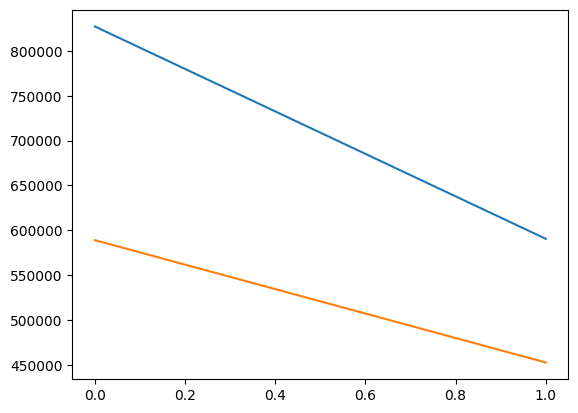

In [26]:
plt.plot(lossi[3:])
plt.plot(dev_lossi[3:])

In [12]:
prediction = dev_logits.view(-1, 7, 7, 10)

In [13]:
def yolo_label_to_cxcywh(label, img_size, S=7, absolute_pixl_values=False):
    #we assume imput size to be (S x S x 5)
    all_converted = []
    img_w, img_h = img_size
    cell_w, cell_h =  img_w/S, img_h/S
    for row in range(S):
        for col in range(S):
            #if its a bbox then confidace will be 1
            if label[row][col][0] == 1: 
                relative_x, relative_y = label[row][col][1], label[row][col][2]
                relative_w, relative_h = label[row][col][3], label[row][col][4]

                #these are in absolute pxl values not 0-1
                true_x = (col + relative_x) * cell_w
                true_y = (row + relative_y) * cell_h
                true_w = relative_w * cell_w
                true_h = relative_h * cell_h

                if absolute_pixl_values:
                    all_converted.append(torch.tensor([1, true_x, true_y, true_w, true_h]))
                else:
                #to make it 0-1
                    all_converted.append(torch.tensor([1, true_x/img_w, true_y/img_h, true_w/img_w, true_h/img_h]))
                    
    return torch.stack(all_converted)

In [14]:
def yolo_labels_to_xyxy(labels, S=7):
    #we assume imput size to be (BatchSize x S x S x 5)
    all_converted = []    
    for label in labels:
        batch_converted = []
        for row in range(S):
            for col in range(S):
                #if its a bbox then confidace will be 1
                if label[row][col][0] == 1: 
                    relative_x, relative_y = label[row][col][1], label[row][col][2]
                    relative_w, relative_h = label[row][col][3], label[row][col][4]

                    x_img = (col + relative_x) / S
                    y_img = (row + relative_y) / S
                    w_img = relative_w / S
                    h_img = relative_h / S
                    
                    x1 = x_img - w_img / 2
                    y1 = y_img - h_img / 2
                    x2 = x_img + w_img / 2
                    y2 = y_img + h_img / 2


                    batch_converted.append(torch.tensor([1, x1, y1, x2, y2]))
                        
        all_converted.append(torch.stack(batch_converted))
    return all_converted

In [15]:
def non_max_supp(preds, confidence_threshold = 0.3, iou_threshold=0.5, S=7, return_type='xywh'):
    batch_size = preds.shape[0]
    all_res = []


    for i in range(batch_size):
        pred = preds[i]

        all_scores = []
        all_boxes_xyxy = []
        all_boxes_xywh = []
        for row in range(S):
            for col in range(S):

                if pred[row, col][0] < confidence_threshold:
                    continue


                x_cell, y_cell, w_cell, h_cell = pred[row, col][1:5]
                
                x_img = (col + x_cell) / S
                y_img = (row + y_cell) / S
                w_img = w_cell / S
                h_img = h_cell / S
                
                x1 = x_img - w_img / 2
                y1 = y_img - h_img / 2
                x2 = x_img + w_img / 2
                y2 = y_img + h_img / 2

                all_scores.append(pred[row, col][0])
                all_boxes_xyxy.append(torch.tensor((x1,y1,x2,y2))) #for the nms calculation
                all_boxes_xywh.append(torch.tensor((x_img,y_img,w_img,h_img))) #for we will use to plot easy later

        #if no prediction has highenough confidace then we get rid of it
        if len(all_boxes_xyxy) == 0:
            all_res.append(torch.tensor([]))
            continue

        #here we get the idx of the valid boxes after non max suppreshion
        res = ops.nms(torch.stack(all_boxes_xyxy), torch.stack(all_scores), iou_threshold=iou_threshold)
        # for each of the idx we combine now with confidacne  
        if return_type == 'xywh':
            keep_boxes = [ torch.cat((all_scores[idx].unsqueeze(0), all_boxes_xywh[idx][:])) for idx in res]
        elif return_type == 'xyxy':
            keep_boxes = [ torch.cat((all_scores[idx].unsqueeze(0), all_boxes_xyxy[idx][:])) for idx in res]
        #we append to the total preds list for each batch
        all_res.append(torch.stack(keep_boxes))
        
    return all_res


            

In [16]:
res  = non_max_supp(prediction.detach().cpu(), return_type='xyxy')

In [17]:
def plot_post_non_max(img, preds, preds_type='cx,cy,w,h', labels=[], labels_type='cx,cy,w,h'):
    img = img.permute(1, 2, 0) #to go from (3 x W x H) to (W x H x 3)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    img_w, img_h = img.shape[:2]

    def plot_cxcywh_style(labels, img_w, img_h, color, marker='ro', show_confidance=False):
         for label in labels:
            confidance, center_x, center_y, width, height = label
            center_x, center_y, width, height = int(center_x * img_w), int(center_y * img_h), int(width * img_w), int(height * img_h)
            xmin = center_x - width/2
            xmax = center_x + width/2
            ymin = center_y - height/2
            ymax = center_y + height/2
            
            #  center and text
            if show_confidance:
                plt.text(center_x, center_y, f"{confidance.item():.3f}", bbox=dict(facecolor='white', alpha=0.35, boxstyle='round'), fontsize=8)
            plt.plot(center_x, center_y, marker)

            
            # (horizontal lines)
            plt.hlines(ymin, xmin=xmin, xmax=xmax, colors=color)
            plt.hlines(ymax, xmin=xmin, xmax=xmax, colors=color)
            
            # (vertical lines)
            plt.vlines(xmin, ymin=ymin, ymax=ymax, colors=color)
            plt.vlines(xmax, ymin=ymin, ymax=ymax, colors=color)
         

    if preds_type == 'cx,cy,w,h':
        plot_cxcywh_style(preds, img_w, img_h, 'red', 'ro', True)

    if len(labels) != 0 and labels_type == 'cx,cy,w,h':
        plot_cxcywh_style(labels, img_w, img_h, 'green', 'g1')
    
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1002855..2.6145253].


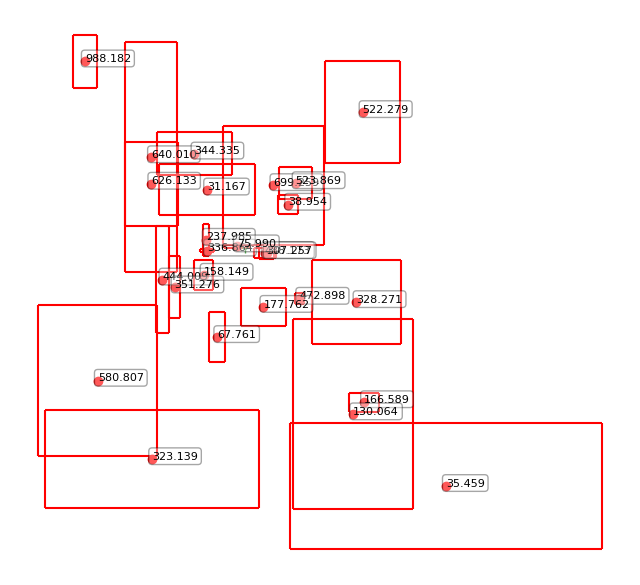

In [18]:
idx = 2
plot_post_non_max(X_dev[idx].cpu(), res[idx], labels=yolo_label_to_cxcywh(y_dev[idx], (224,224)))

In [19]:
y_dev_xyxy = yolo_labels_to_xyxy(y_dev)

In [20]:
import numpy as np
import torch
import torchvision.ops as ops

def mAP(preds, labels, iou_start=0.5, iou_stop=0.95, iou_step=0.05):
    # expected shape for preds is (BatchSize x num_preds x 5)
    # expected shape for labels is (BatchSize x num_true_labels x 5)
    
    mAPs = [] #for each iou  threshold
    
    for iou_thresh in np.arange(start=iou_start, stop=iou_stop + iou_step/2, step=iou_step):
        batch_aps = []
        
        for img_idx in range(len(preds)):
            img_preds = preds[img_idx]
            img_labels = labels[img_idx]
            
            # skip if no preds or labels
            if len(img_preds) == 0 or len(img_labels) == 0:
                continue
                
            ious = ops.box_iou(img_preds[:, 1:5], img_labels[:, 1:5])
            
            # sort preds by confidance 
            conf_sorted_indices = torch.argsort(img_preds[:, 0], descending=True)
            
            true_positives = torch.zeros(len(img_preds))
            false_positives = torch.zeros(len(img_preds))
            
            # track which true lables have been used
            used_gt = torch.zeros(len(img_labels))
            
            for pred_idx in conf_sorted_indices:
                best_iou, best_gt_idx = torch.max(ious[pred_idx], dim=0)
                
                if best_iou >= iou_thresh and not used_gt[best_gt_idx]:
                    true_positives[pred_idx] = 1
                    used_gt[best_gt_idx] = True
                else:
                    false_positives[pred_idx] = 1
            
            cum_tp = torch.cumsum(true_positives[conf_sorted_indices], dim=0)
            cum_fp = torch.cumsum(false_positives[conf_sorted_indices], dim=0)
            precision = cum_tp / (cum_tp + cum_fp)
            recall = cum_tp / len(img_labels)
            
            # add (precision=1 recall=0 )and (precision=0  recall=1) 
            precision = torch.cat([torch.tensor([1.0]), precision, torch.tensor([0.0])])
            recall = torch.cat([torch.tensor([0.0]), recall, torch.tensor([1.0])])
            
            # calc teh ap on the per img level
            ap = torch.trapezoid(precision, recall)
            batch_aps.append(ap.item())
        
        # mean across al imgs at this iou level
        if batch_aps:
            mAPs.append(sum(batch_aps) / len(batch_aps))
    
    return sum(mAPs) / len(mAPs)
    # if mAPs:
    #     return sum(mAPs) / len(mAPs)
    # else:
    #     return 0.0

In [21]:
mAP(non_max_supp(prediction.detach().cpu(), return_type='xyxy'), y_dev_xyxy) #, iou_start=0.1, iou_stop=0.5)

0.0

In [22]:
X_me00 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_side.pt')
X_me01 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_straighton.pt')
X_me02 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun_hand.pt')
X_me03 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun.pt')

me_full = torch.stack((X_me00,X_me01, X_me02, X_me03))

FileNotFoundError: [Errno 2] No such file or directory: '/home/kuba/Documents/data/raw/me-img/tensor/clear_side.pt'

In [ ]:
me_full.shape


torch.Size([4, 3, 224, 224])

In [ ]:
img_num = 3
model_cpu = model.cpu()
logits = (model(me_full[img_num].unsqueeze(dim=0))).squeeze()
prediction = logits.view(-1, 7, 7, 10)
draw_bounding_boxes(me_full[img_num].cpu(), prediction[0].detach().cpu())


NameError: name 'me_full' is not defined